## 04. 详解优化器

### 实例化优化器对象

在Basic Tutorial中，我们知道UltraOpt中有如下优化器：

|优化器|描述|
|-----|---|
|ETPE| Embedding-Tree-Parzen-Estimator, 是UltraOpt作者自创的一种优化算法，在TPE算法[<sup>[4]</sup>](#refer-anchor-4)的基础上对类别变量采用Embedding降维为低维连续变量，<br>并在其他的一些方面也做了改进。ETPE在某些场景下表现比HyperOpt的TPE算法要好。 |
|Forest |基于随机森林的贝叶斯优化算法。概率模型引用了`scikit-optimize`[<sup>[1]</sup>](#refer-anchor-1)包的`skopt.learning.forest`模型[<sup>[2]</sup>](#refer-anchor-2)，<br>并借鉴了`SMAC3`[<sup>[3]</sup>](#refer-anchor-3)中的局部搜索方法|
|GBRT| 基于梯度提升回归树(Gradient Boosting Resgression Tree)的贝叶斯优化算法，<br>概率模型引用了`scikit-optimize`包的`skopt.learning.gbrt`模型 |
|Random| 随机搜索。 |

我们在调用`ultraopt.fmin`函数进行优化时，在使用优化器默认参数的情况下，可以只传入优化器的名字，如：

```python
from ultraopt import fmin

result = fmin(evaluate_function, config_space, optimizer="ETPE")
```


但如果我们要调整优化器的参数，如修改`ForestOptimizer`随机森林树的个数，或 `ETPEOptimizer` 的一些涉及冷启动和采样个数的参数时，就需要从`ultraopt.optimizer`包中引入相应的优化类，并对其实例化为优化器对象

引入`fmin`和你需要使用的优化器类：

In [1]:
from ultraopt import fmin
from ultraopt.optimizer import ETPEOptimizer
from ultraopt.optimizer import RandomOptimizer
from ultraopt.optimizer import ForestOptimizer
from ultraopt.optimizer import GBRTOptimizer

引入一个测试用的配置空间和评价函数：

In [2]:
from ultraopt.tests.mock import config_space, evaluate

根据自己想要的参数实例化一个`ForestOptimizer`：

In [3]:
optimizer = ForestOptimizer(n_estimators=20) # 代理模型为20棵树的随机森林

把优化器对象传入fmin函数，开始优化过程

In [4]:
fmin(evaluate, config_space, optimizer)

100%|██████████| 100/100 [00:04<00:00, 20.13trial/s, best loss: 2.505]


+---------------------------------+
| HyperParameters | Optimal Value |
+-----------------+---------------+
| x0              | -0.5365       |
| x1              | 0.3258        |
+-----------------+---------------+
| Optimal Loss    | 2.5050        |
+-----------------+---------------+
| Num Configs     | 100           |
+-----------------+---------------+

### 不用fmin函数自己实现一个优化过程

优化器有3个重要的函数：

- `initialize(config_space, ...` : 参数为配置空间等，初始化优化器
- `ask(n_points=None , ...` : 请求优化器推荐`n_points`个配置（默认为1个）
- `tell(config, loss, ...)` : 告知优化器，之前推荐配置`config`的好坏（损失`loss`越小越好）

优化器的运行流程如下图所示：

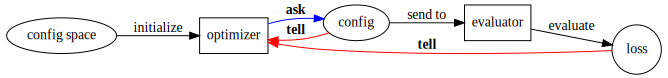

In [5]:
from graphviz import Digraph; g = Digraph()
g.node("config space", shape="ellipse"); g.node("optimizer", shape="box")
g.node("config", shape="ellipse"); g.node("loss", shape="circle"); g.node("evaluator", shape="box")
g.edge("config space", "optimizer", label="initialize"); g.edge("optimizer", "config", label="<<b>ask</b>>", color='blue')
g.edge("config","evaluator" , label="send to"); g.edge("evaluator","loss" , label="evaluate")
g.edge("config", "optimizer", label="<<b>tell</b>>", color='red'); g.edge("loss", "optimizer", label="<<b>tell</b>>", color='red')
g.graph_attr['rankdir'] = 'LR'; g

图中的`evaluator`评价器会对`config`配置进行评价，然后返回一个损失`loss`。

举个例子，在AutoML问题中，评价器的工作流程如下：
1. 将config转化为一个机器学习实例
2. 在训练集上对机器学习实例进行训练
3. 在验证集上得到相应的评价指标
4. 对评价指标进行处理，使其`越小越好`，返回`loss`

具体的评价器我们会在下个教程中实现。在学习了这些知识后， 我们能否脱离`fmin`函数，自己实现一个优化过程呢？答案是可以的。

在UltraOpt的设计哲学中，优化器只需要具备上述的3个接口，评价器和分布式策略的设计都可以由用户完成。

#### 先从一次循环中体会整个过程

> Step 1. 首先实例化和初始化优化器

In [6]:
optimizer = ETPEOptimizer()
optimizer.initialize(config_space)

> Step 2. 调用优化器的`ask`函数获取一个其推荐的配置：

In [7]:
recommend_config, config_info = optimizer.ask()
recommend_config

{'x0': 6.632914250425159, 'x1': 1.830923578719112}

In [8]:
config_info

{'model_based_pick': False, 'origin': 'Initial Design'}

> Step 3. 用评估器，在这是`evaluate`函数来评价配置的好坏

In [9]:
loss = evaluate(recommend_config)
loss

177817.31410476987

> Step 4. 通过tell函数将观测结果 `config, loss` 传递给优化器

In [10]:
optimizer.tell(recommend_config, loss)

#### 将上述过程整理为一个for循环

In [11]:
optimizer = ETPEOptimizer()
optimizer.initialize(config_space)
losses = []
best_losses = []
for _ in range(100):
    config, _ = optimizer.ask()
    loss = evaluate(config)
    optimizer.tell(config, loss)
    losses.append(loss)
    best_losses.append(min(losses))

In [12]:
import pylab as plt

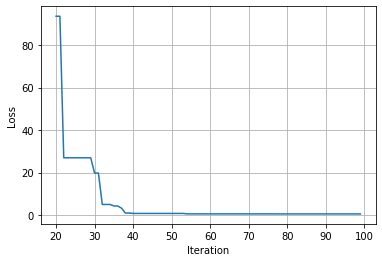

In [13]:
plt.grid(0.2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(20, 100), best_losses[20:]);

您可能会有疑问，一次只能`ask`一个推荐配置吗，能不能`ask`多个呢？答案是可以的

#### MapReduce计算策略：ask多个配置 + 并行调用评价函数

In [14]:
from joblib import Parallel, delayed

In [15]:
n_parallels = 3

In [16]:
optimizer = ETPEOptimizer()
optimizer.initialize(config_space)

for _ in range(100 // n_parallels):
    config_info_pairs = optimizer.ask(n_points=n_parallels)
    losses = Parallel(n_jobs=n_parallels)(
        delayed(evaluate)(config)
        for config, _ in config_info_pairs
    )
    loss = evaluate(config)
    for j, (loss, (config, _)) in enumerate(zip(losses, config_info_pairs)):
        optimizer.tell(config, loss, update_model=(j == n_parallels - 1)) # 传入这批观测的最后一个观测时，更新模型


**参考文献**

<div id="refer-anchor-1"></div>

- [1] https://github.com/scikit-optimize/scikit-optimize

<div id="refer-anchor-2"></div>

- [2] [Hutter, F. et al. “Algorithm runtime prediction: Methods & evaluation.” Artif. Intell. 206 (2014): 79-111.](https://arxiv.org/abs/1211.0906)

<div id="refer-anchor-3"></div>

- [3] [Hutter F., Hoos H.H., Leyton-Brown K. (2011) Sequential Model-Based Optimization for General Algorithm Configuration. In: Coello C.A.C. (eds) Learning and Intelligent Optimization. LION 2011. Lecture Notes in Computer Science, vol 6683. Springer, Berlin, Heidelberg.](https://link.springer.com/chapter/10.1007/978-3-642-25566-3_40)

<div id="refer-anchor-4"></div>

- [4] [James Bergstra, Rémi Bardenet, Yoshua Bengio, and Balázs Kégl. 2011. Algorithms for hyper-parameter optimization. In Proceedings of the 24th International Conference on Neural Information Processing Systems (NIPS'11). Curran Associates Inc., Red Hook, NY, USA, 2546–2554.](https://dl.acm.org/doi/10.5555/2986459.2986743)
